In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

In [2]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()
sc = spark.sparkContext

# A JSON dataset is pointed to by path.
# The path can be either a single text file or a directory storing text files

In [3]:
path = "wallets_test"
path = "wallets"
wallets_df = spark.read.json(path)

wallets = wallets_df.rdd.map(lambda w: w.asDict(True)) 

In [4]:
wallet_transactions = wallets.flatMap(lambda w:  [ (w['address'], tx) for tx in w['txs'] or [] ] ) \
                                .map(lambda w:  (w[0], (w[1].get('incoming'), w[1].get('outgoing'))  ))


balance = wallets.map(lambda w: (w['address'], float(w['balance'] or 0)))
received_value = wallets.map(lambda w: (w['address'], float(w['received_value'] or 0 )))
total_txs = wallets.map(lambda w: (w['address'], float(w['total_txs'] or 0)  ))
txs_in  = wallet_transactions.mapValues(lambda w:   w[0] ).filter(lambda w: w[1] is not None)
txs_out = wallet_transactions.mapValues(lambda w:   w[1] ).filter(lambda w: w[1] is not None)

a_in  = txs_in.flatMapValues(lambda tx: tx.get('inputs',[])).mapValues(lambda tx: tx['address'])
a_out = txs_out.flatMapValues(lambda tx: tx.get('outputs',[])).mapValues(lambda tx: tx['address'])

v_in  = txs_in.mapValues(lambda w:    float(w['value'] or 0) )
v_out = txs_out.mapValues(lambda w:   float(w['value'] or 0) )

# features

avg_vin = v_in.mapValues(lambda v: (v,1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1] )).mapValues(lambda x: x[0]/x[1])
avg_vout =  v_out.mapValues(lambda v: (v,1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1] )).mapValues(lambda x: x[0]/x[1])

var_vin = v_in.join(avg_vin).mapValues(lambda v: ((v[0]-v[1])**2,1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1] )).mapValues(lambda x: x[0]/x[1])
var_vout =  v_out.join(avg_vout).mapValues(lambda v: ((v[0]-v[1])**2,1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1] )).mapValues(lambda x: x[0]/x[1])

unique_deg_in = a_in.mapValues( lambda x: {x}).reduceByKey((lambda a, b: a.union(b))).mapValues(len)
unique_deg_out = a_out.mapValues( lambda x: {x}).reduceByKey((lambda a, b: a.union(b))).mapValues(len)

deg_in = a_in.mapValues(lambda x: 1).reduceByKey(lambda a, b: a + b)
deg_out = a_out.mapValues(lambda x: 1).reduceByKey(lambda a, b: a + b)

# unique_deg_in.collect(), deg_in.collect()
v_in.first(), v_out.first()

(('1KTpWQBcBFCwoRSxtdj7TAs24ip4mitaRU', 1.0),
 ('1KTpWQBcBFCwoRSxtdj7TAs24ip4mitaRU', 1.0))

In [5]:
rdds = [ avg_vin, avg_vout, var_vin, var_vout, unique_deg_in, unique_deg_out, deg_in, deg_out, balance, received_value, total_txs]
names = [ 'avg_vin', 'avg_vout', 'var_vin', 'var_vout', 'unique_deg_in', 'unique_deg_out', 'deg_in', 'deg_out', 'balance', 'received_value', 'total_txs']

final_df = None
for rdd, name in zip(rdds, names):
    df = rdd.toDF(['addr', name ])
    print(df)
    if final_df is None:
        final_df = df
    else:
        final_df = final_df.join(df,'addr', 'outer')

DataFrame[addr: string, avg_vin: double]
DataFrame[addr: string, avg_vout: double]
DataFrame[addr: string, var_vin: double]
DataFrame[addr: string, var_vout: double]
DataFrame[addr: string, unique_deg_in: bigint]
DataFrame[addr: string, unique_deg_out: bigint]
DataFrame[addr: string, deg_in: bigint]
DataFrame[addr: string, deg_out: bigint]
DataFrame[addr: string, balance: double]
DataFrame[addr: string, received_value: double]
DataFrame[addr: string, total_txs: double]


In [6]:
pandas_df = final_df.fillna(0).toPandas()
pandas_df

,addr,avg_vin,avg_vout,var_vin,var_vout,unique_deg_in,unique_deg_out,deg_in,deg_out,balance,received_value,total_txs
0,112NDgsBxonbMHKe4NqrCzuaBMDzTj66Ax,0.004581,0.004668,1.310102e-05,0.000013,21,26,32,50,0.000194,0.322902,40.0
1,115xveCM7QPtDMZThzCz9t6Cgh8mVqdNLr,0.001980,0.000000,0.000000e+00,0.000000,3,0,3,0,0.001980,0.001980,1.0
2,125ycExUXrps7Zh5YJGwnwWPWzHhw8dnmQ,0.009331,0.010922,7.240660e-05,0.000152,49,23,54,23,0.013890,23.612875,1133.0
3,12crW4pQ4ZJ3naUcB4fXDGzLM3gPLNAFuD,0.003444,0.002080,1.069924e-05,0.000003,6,1,6,4,0.012343,0.020664,6.0
4,12nUtx4AT1unn64ihiXPawwBUeNnz2oH4M,0.001023,0.001023,0.000000e+00,0.000000,1,2,1,2,0.000000,0.001023,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
148417,bc1qzhrhkew8zemfzkv3flpynsxcwnxgrgthhq50dp,0.001142,0.000000,6.442600e-09,0.000000,30,0,31,0,0.035407,0.035407,31.0
148418,bc1qznjfu7ka20nuvpzxeehw36gk87lcqd7t774sjn,0.312495,0.000000,0.000000e+00,0.000000,1,0,1,0,0.312495,0.312495,1.0
148419,bc1qzqn0tzqfrglg3yml384mwh0x8vh7rxkclxje93,0.005879,0.005879,0.000000e+00,0.000000,1,1,1,1,0.000000,0.005879,1.0
148420,bc1qztlsjvhyefc720trc6nk8pzvgzv2em6ava0pfz,0.001475,0.001475,0.000000e+00,0.000000,1,2,1,2,0.000000,0.001475,1.0


In [7]:
from database import *

pandas_df.to_sql('wallets_meta', engine,  if_exists='replace', index=False, )

### Machine Learning
Here there is code for PCA + KMeans

In [8]:
import sklearn.preprocessing
import pandas as pd

pandas_df = pd.read_sql_table('wallets_meta', engine)

data = pandas_df.loc[:, pandas_df.columns != 'addr'].to_numpy()
norm_data = sklearn.preprocessing.normalize(data)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca = pca.fit(norm_data)
grid = pca.transform(norm_data)

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(6)
kmeans.fit(norm_data)
color_number = kmeans.predict(norm_data)

colors = [ ['r','g','b','y','m','k'][i] for i in color_number]
# print(colors)

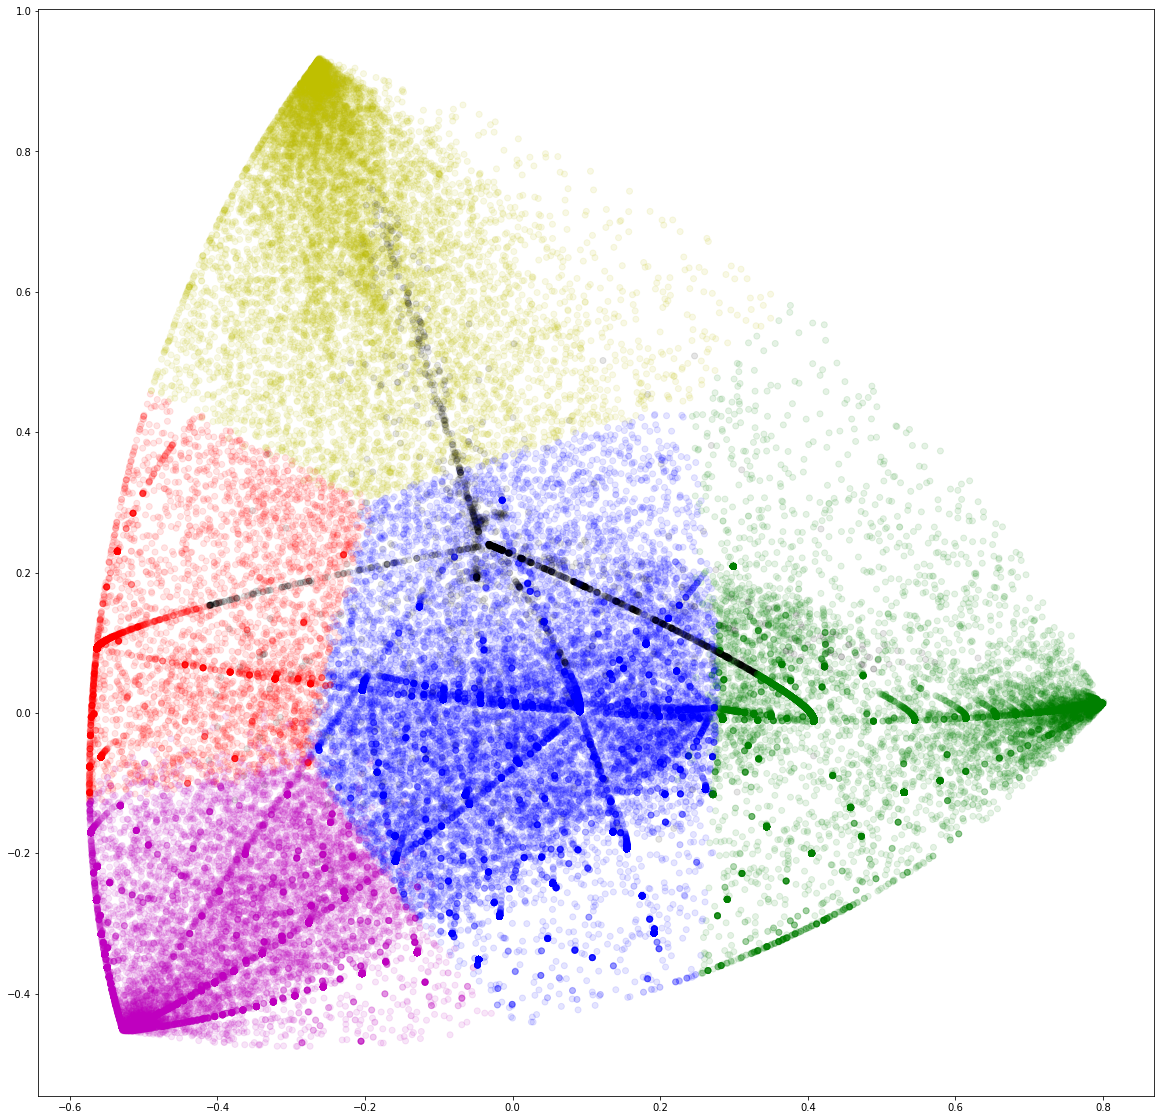

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.scatter(*grid.T, c=colors, alpha=0.1)